<a href="https://colab.research.google.com/github/SantonioTheFirst/U-netImageSegmentation/blob/main/ShipsSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c airbus-ship-detection

100% 28.6G/28.6G [06:14<00:00, 120MB/s]
100% 28.6G/28.6G [06:14<00:00, 82.0MB/s]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
!unzip -q airbus-ship-detection.zip

In [ ]:
df = pd.read_csv('train_ship_segmentations_v2.csv')
df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


Добавим функцию, чтобы в дальнейшем считать заполненность изображений

In [ ]:
image_shape = (768, 768)

def get_image_height_width(data):
    data['Height'], data['Width'] = image_shape
    return data

In [ ]:
df = df.apply(lambda x: get_image_height_width(x), axis=1)

In [ ]:
df.head()

,ImageId,EncodedPixels,Height,Width
0,00003e153.jpg,NaN,768,768
1,0001124c7.jpg,NaN,768,768
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,768,768
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,768,768
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,768,768


In [ ]:
df.shape

(231723, 4)

In [ ]:
df.dtypes

ImageId          object
EncodedPixels    object
Height            int64
Width             int64
dtype: object

In [ ]:
def get_percentage(data):
    # print(data)
    if pd.isna(data):
        return 0
    return np.array(data.split(), dtype=int)[1::2].sum()

In [ ]:
num_pixels = image_shape[0] * image_shape[1]

In [ ]:
df['EncodedPixels'] = df['EncodedPixels'].astype('string')

In [ ]:
df['FillPercentage'] = df.apply(lambda x: get_percentage(x['EncodedPixels']) / num_pixels * 100, axis=1)

Рассчитали заполненность для кадого изображения

In [ ]:
df.head()

,ImageId,EncodedPixels,Height,Width,FillPercentage
0,00003e153.jpg,<NA>,768,768,0.000000
1,0001124c7.jpg,<NA>,768,768,0.000000
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,768,768,0.574409
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,768,768,0.030009
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,768,768,0.025092


In [ ]:
df.isna().sum().sum()

150000

In [ ]:
df['ImageId'].nunique()

192556

Посмотрим распределение количества кораблей

In [ ]:
ship_counts_df = df.groupby(['ImageId'], as_index=False).agg({'EncodedPixels' : 'count'})\
.rename(columns={'EncodedPixels' : 'ShipsNumber'})

In [ ]:
ship_counts_df

,ImageId,ShipsNumber
0,00003e153.jpg,0
1,0001124c7.jpg,0
2,000155de5.jpg,1
3,000194a2d.jpg,5
4,0001b1832.jpg,0
...,...,...
192551,fffedbb6b.jpg,0
192552,ffff2aa57.jpg,0
192553,ffff6e525.jpg,0
192554,ffffc50b4.jpg,0


<Axes: >

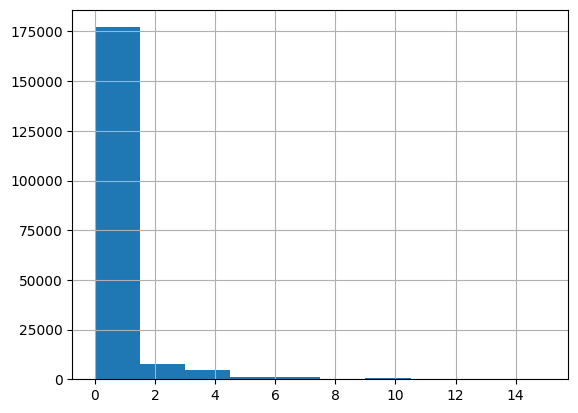

In [ ]:
ship_counts_df['ShipsNumber'].hist()

<Axes: >

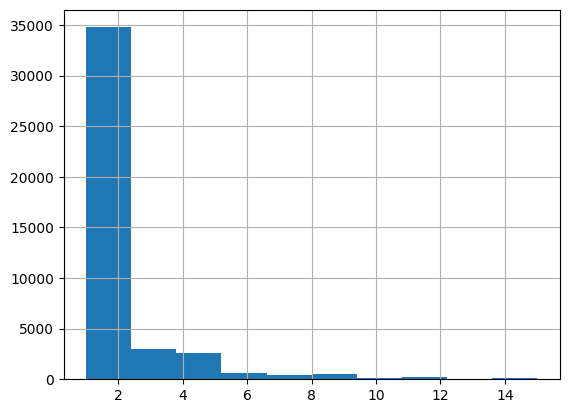

In [ ]:
ship_counts_df[ship_counts_df['ShipsNumber'] != 0]['ShipsNumber'].hist()

Подавляющее большинство изображений либо не содержит ни одного корабля, либо содержат 1-2 корабля.

In [ ]:
import cv2

Функция для декодирования изображений и их отображения

In [ ]:
def show_encoded_image(img_id, ret=False):
    images = df[df['ImageId'] == img_id] # достаем все изображения по идентификатору
    if len(images) == 0:
        return
    # print(images['EncodedPixels'].isna().any())
    if images['EncodedPixels'].isna().all() and ret:
        return np.zeros((768, 768, 1), dtype=bool)
    path = f'train_v2/{img_id}'
    image = cv2.imread(path)
    image_size, _, _ = image.shape
    ship_count = len(images) # достаем количество масок для изображения
    all_ships = np.zeros((*image_shape, 1), dtype=np.uint8)

    if not ret:
        ax_rows_number = ship_count + 1
        f,ax = plt.subplots(ax_rows_number, 3, figsize=(15, 5 * ax_rows_number))

    for i in range(ship_count): # пробегаемся по каждой маске
        image_info = images.iloc[i]
        # декодируем каждую маску и складываем их
        encoded_pixels = np.array(image_info['EncodedPixels'].split(), dtype=int)
        pixels, shift = encoded_pixels[::2], encoded_pixels[1::2]
        ship = np.zeros((*image_shape, 1), dtype=np.uint8)

        for pixel, shift in zip(pixels, shift):
            for j in range(shift):
                cur_pixel = pixel + j - 1
                ship[cur_pixel % image_size, cur_pixel // image_size] = [255]
        all_ships += ship
        
        # выводим изображения
        if not ret:
            ax[i, 0].imshow(image)
            ax[i, 1].imshow(ship)
            ax[i, 2].imshow(image * (ship // 255))
    if not ret:
        ax[ship_count, 0].imshow(image)
        ax[ship_count, 1].imshow(all_ships)
        print(all_ships.shape)
        ax[ship_count, 2].imshow(image * (all_ships // 255))
        plt.show()
    else:
        return all_ships

(768, 768, 1)


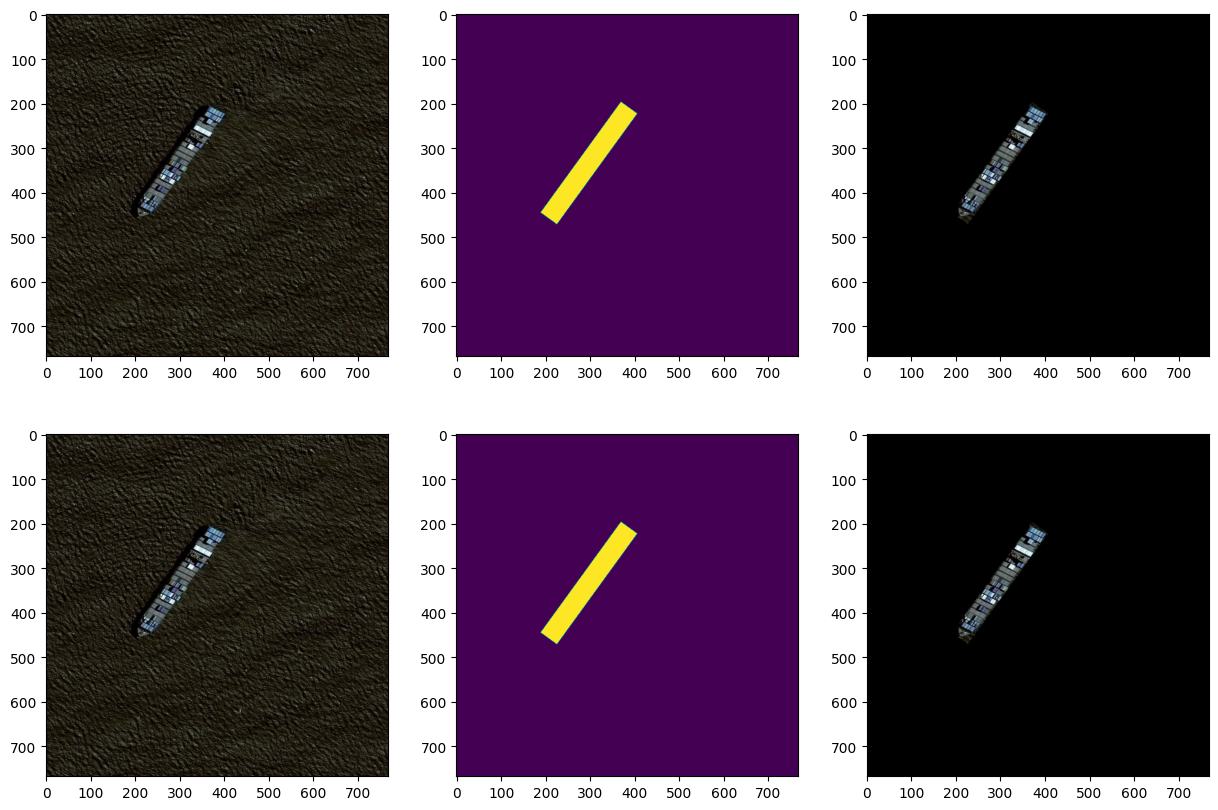

In [ ]:
image_id = '0006c52e8.jpg'
show_encoded_image(image_id)

(768, 768, 1)


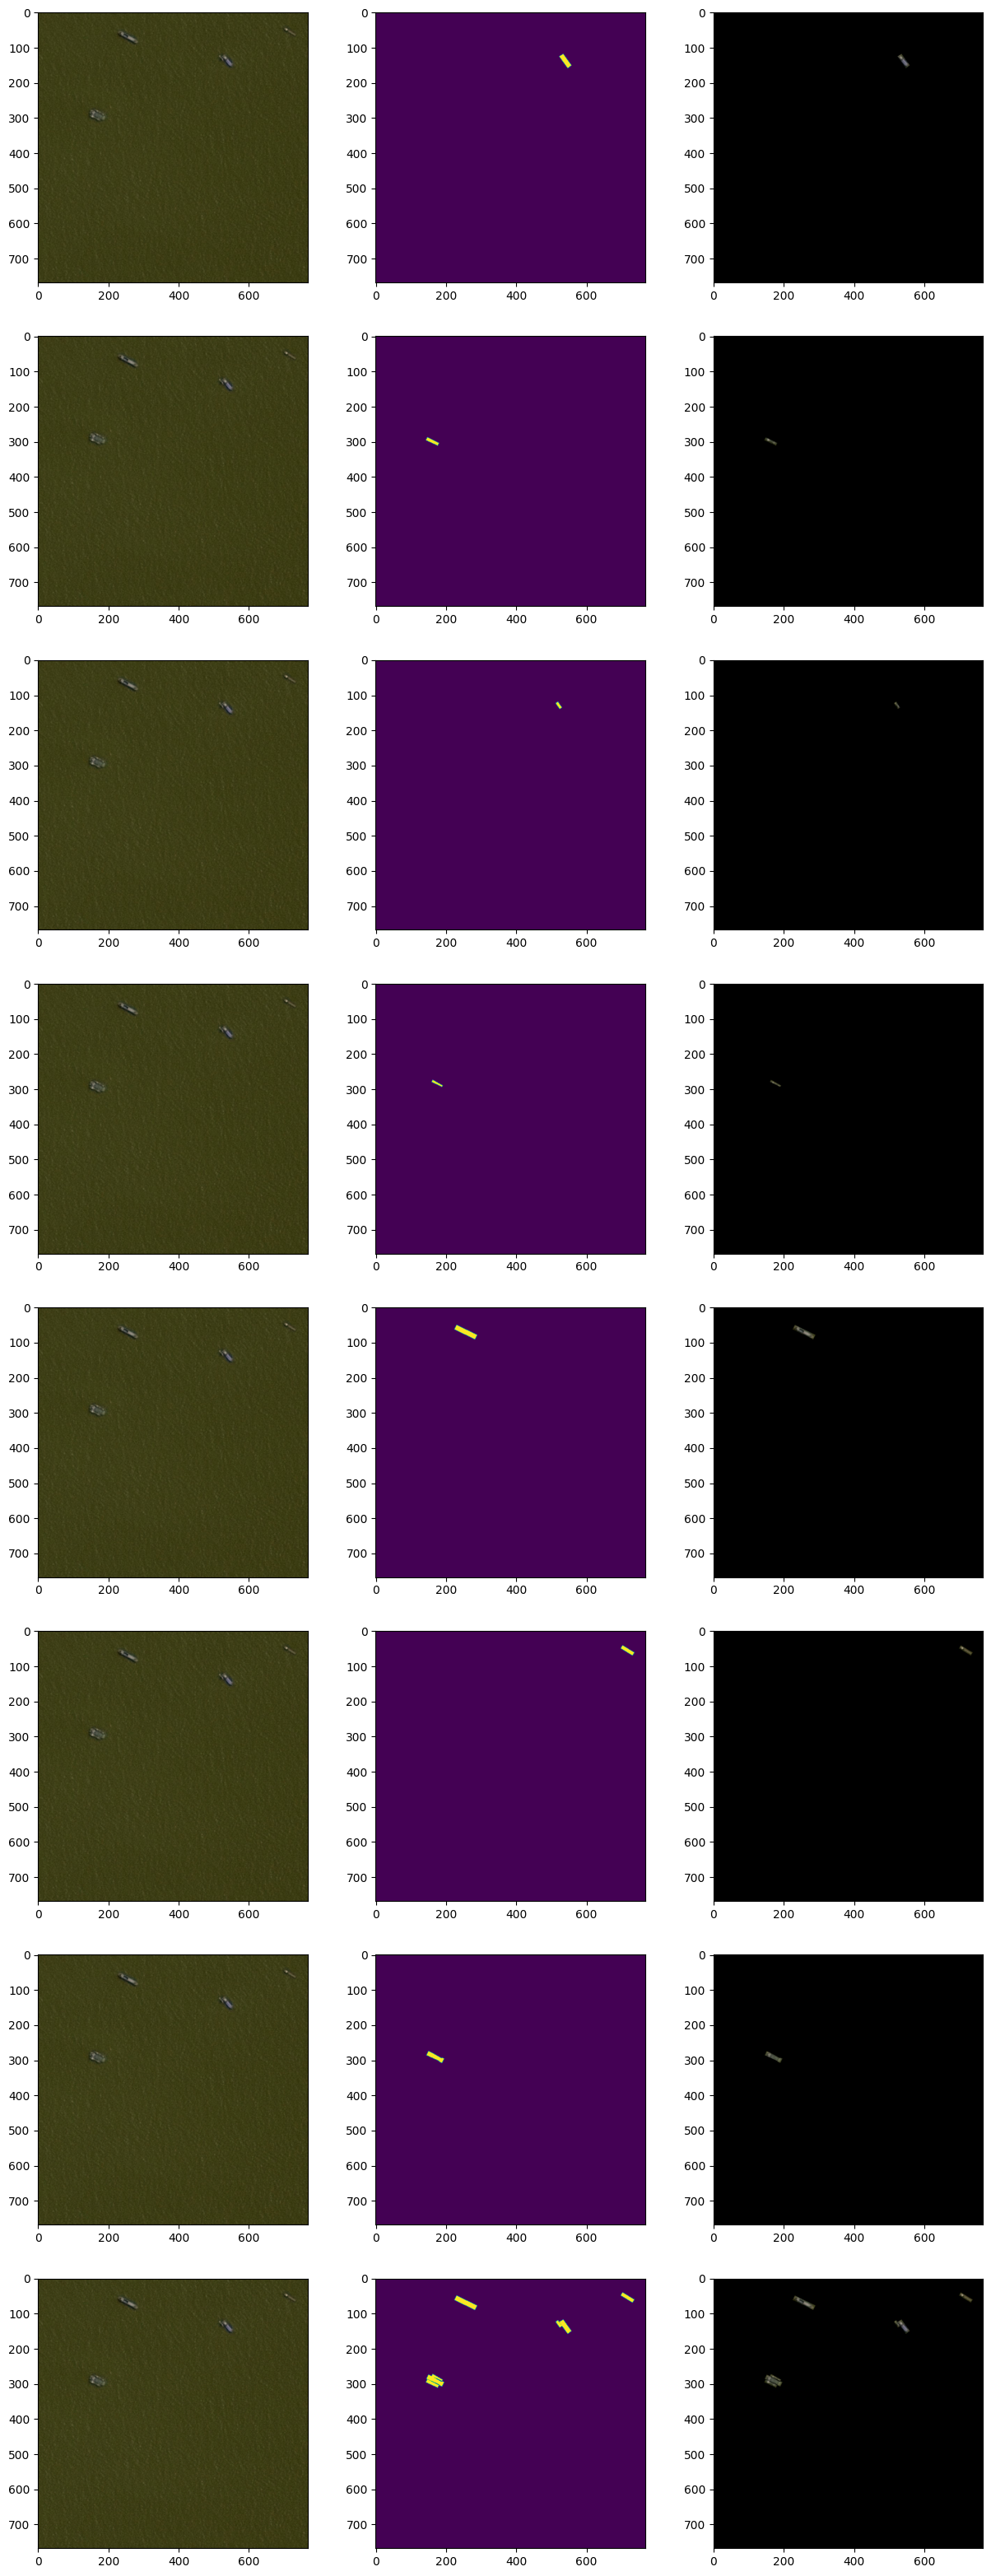

In [ ]:
image_id = '00113a75c.jpg'
show_encoded_image(image_id)

Выберем только 10 тысяч изображений без кораблей

In [ ]:
without_ships_number = 10000

In [ ]:
without_ships = df[df['EncodedPixels'].isna()].iloc[:without_ships_number]
without_ships

,ImageId,EncodedPixels,Height,Width,FillPercentage
0,00003e153.jpg,<NA>,768,768,0.0
1,0001124c7.jpg,<NA>,768,768,0.0
8,0001b1832.jpg,<NA>,768,768,0.0
20,0002d0f32.jpg,<NA>,768,768,0.0
21,000303d4d.jpg,<NA>,768,768,0.0
...,...,...,...,...,...
15534,1105c6f28.jpg,<NA>,768,768,0.0
15535,1105d1c53.jpg,<NA>,768,768,0.0
15536,1105ffd59.jpg,<NA>,768,768,0.0
15538,11067b923.jpg,<NA>,768,768,0.0


In [ ]:
with_ships_ids = df[df['EncodedPixels'].notna()]['ImageId'].unique()
len(with_ships_ids)

42556

In [ ]:
with_ships_number = len(with_ships_ids)

In [ ]:
with_ships_ids = with_ships_ids[:with_ships_number]

In [ ]:
with_ships = df.query('ImageId in @with_ships_ids').copy()

In [ ]:
train = pd.concat([without_ships, with_ships])

In [ ]:
train['ImageId'].nunique()

52556

Сохраняем полученный датафрейм

In [ ]:
train.to_csv('train.csv')

In [ ]:
import os

Создаем структуру каталогов

In [ ]:
os.mkdir('train')
os.mkdir('train/image')
os.mkdir('train/mask')

FileExistsError: ignored

In [ ]:
os.mkdir('train/image/img')
os.mkdir('train/mask/img')

In [ ]:
image_ids = train['ImageId'].unique()

In [ ]:
from tqdm import tqdm

Распределяем изображения и маски на обучение и отложенную тестовую выборку

In [ ]:
for i, image_id in tqdm(enumerate(image_ids), total=len(image_ids)):
    os.system(f'cp train_v2/{image_id} train/image/img')

100%|██████████| 52556/52556 [07:03<00:00, 124.09it/s]


In [ ]:
test_ratio = 0.2
test_num = int(len(image_ids) * test_ratio)

In [ ]:
test_ids = train.sample(frac=1, random_state=7)['ImageId'].iloc[:test_num]

In [ ]:
len(test_ids)

10511

In [ ]:
os.mkdir('test')
os.mkdir('test/image')
os.mkdir('test/mask')
os.mkdir('test/image/img')
os.mkdir('test/mask/img')

In [ ]:
for i, image_id in tqdm(enumerate(test_ids), total=len(test_ids)):
    os.system(f'mv train/image/img/{image_id} test/image/img')

100%|██████████| 10511/10511 [00:24<00:00, 424.67it/s]


In [ ]:
len(os.listdir('train/image/img')) + len(os.listdir('test/image/img'))

52556

Функция для получения маски для изображения без вывода изображений на экран

In [ ]:
def get_encoded_image(img_id, read_from):
    images = train[train['ImageId'] == img_id]
    if len(images) == 0:
        return
    if images['EncodedPixels'].isna().all():
        return np.zeros((*image_shape, 1), dtype=bool)
    path = f'{read_from}/image/img/{img_id}'
    image = cv2.imread(path)
    image_size, _, _ = image.shape
    ship_count = len(images)
    all_ships = np.zeros((*image_shape, 1), dtype=np.uint8)

    for i in range(ship_count):
        image_info = images.iloc[i]

        encoded_pixels = np.array(image_info['EncodedPixels'].split(), dtype=int)
        pixels, shift = encoded_pixels[::2], encoded_pixels[1::2]
        ship = np.zeros((*image_shape, 1), dtype=np.uint8)

        for pixel, shift in zip(pixels, shift):
            for j in range(shift):
                cur_pixel = pixel + j - 1
                ship[cur_pixel % image_size, cur_pixel // image_size] = [255]
        all_ships += ship
    return all_ships

In [ ]:
train_images_ids = os.listdir('train/image/img')
test_images_ids = os.listdir('test/image/img')

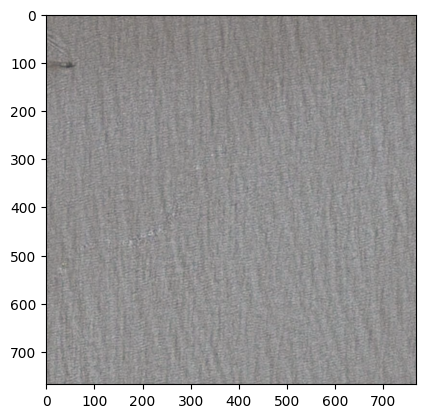

In [ ]:
plt.imshow(cv2.imread(f'train/image/img/{train_images_ids[0]}'))

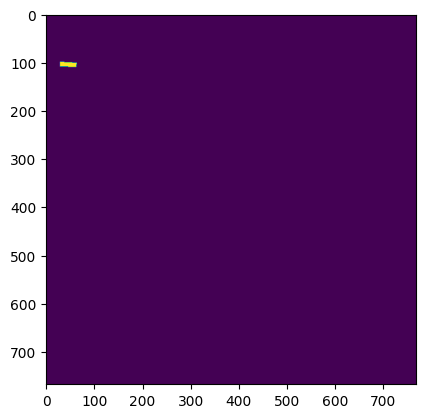

In [ ]:
plt.imshow(get_encoded_image(train_images_ids[0], 'train'))

In [ ]:
import matplotlib.cm as cm

Декодируем маски и сохраняем их по папкам

In [ ]:
for i, img_id in tqdm(enumerate(train_images_ids), total=len(train_images_ids)):
    plt.imsave(f'train/mask/img/{img_id}', get_encoded_image(img_id, 'train').reshape(image_shape), cmap=cm.gray)

100%|██████████| 43192/43192 [40:45<00:00, 17.66it/s]


In [ ]:
test_images_ids = os.listdir('test/image/img')

In [ ]:
for i, img_id in tqdm(enumerate(test_images_ids), total=len(test_images_ids)):
    plt.imsave(f'test/mask/img/{img_id}', get_encoded_image(img_id, 'test').reshape(image_shape), cmap=cm.gray)

100%|██████████| 9364/9364 [08:56<00:00, 17.45it/s]


Сохраняем все наши данные в архив и закидываем его на диск

In [ ]:
!zip -rq data.zip train test train.csv

In [ ]:
!cp data.zip drive/MyDrive/

Перезагружаем среду с использованием графического ускорителя и загружаем сюда данные с диска :)

# Load to GPU

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
import cv2
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Dropout, Lambda, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import backend as K

In [ ]:
os.system('cp drive/MyDrive/data.zip .')

0

In [ ]:
!unzip -q data.zip

In [ ]:
rs = 7
batch_size = 64
image_shape = (256, 256)

Создаем датасеты из папок с изображениями

In [ ]:
train_images_ds, valid_images_ds = image_dataset_from_directory(
    'train/image',
    labels=None,
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=image_shape,
    seed=rs,
    validation_split=0.02,
    subset='both'
)

train_masks_ds, valid_masks_ds = image_dataset_from_directory(
    'train/mask',
    labels=None,
    class_names=None,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=image_shape,
    seed=rs,
    validation_split=0.02,
    subset='both'
)

Found 43192 files belonging to 1 classes.
Using 42329 files for training.
Using 863 files for validation.
Found 43192 files belonging to 1 classes.
Using 42329 files for training.
Using 863 files for validation.


In [ ]:
train_images_ds = train_images_ds.map(lambda x: x / 255.0)
train_masks_ds = train_masks_ds.map(lambda x: x / 255.0)
valid_images_ds = valid_images_ds.map(lambda x: x / 255.0)
valid_masks_ds = valid_masks_ds.map(lambda x: x / 255.0)

In [ ]:
train_ds = tf.data.Dataset.zip((train_images_ds, train_masks_ds)).prefetch(tf.data.AUTOTUNE)
valid_ds = tf.data.Dataset.zip((valid_images_ds, valid_masks_ds)).prefetch(tf.data.AUTOTUNE)

In [ ]:
steps = len(train_ds)

# U-net

In [ ]:
IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS = 256, 256, 3

Описываем функции для расчета метрики качества и ошибки

In [ ]:
def dice_coef(y_true, y_pred, smooth=100):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

Описание структуры сети

In [ ]:
input = Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
# s = Lambda(lambda x: x / 255.0)(input)
c1 = Conv2D(16, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(input)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(p2)
c3 = Dropout(0.1)(c3)
c3 = Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(c3)
p3 = MaxPooling2D((2, 2))(c3)

c4 = Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(p3)
c4 = Dropout(0.1)(c4)
c4 = Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(c4)
p4 = MaxPooling2D((2, 2))(c4)

c5 = Conv2D(256, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(p4)
c5 = Dropout(0.1)(c5)
c5 = Conv2D(256, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(c5)

# up
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5) #c5
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(u6)
c6 = Dropout(0.1)(c6)
c6 = Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(u7)
c7 = Dropout(0.1)(c7)
c7 = Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7) #c7
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = concatenate([u9, c1])
c9 = Conv2D(16, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(16, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(c9)

output = Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = Model(inputs=[input], outputs=[output])
# model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer=Adam(learning_rate=0.0001), loss=dice_coef_loss, metrics=['accuracy', dice_coef])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 256, 256, 16  0           ['conv2d_19[0][0]']              
                                )                                                           

Импорт колбеков и обучение

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
es = EarlyStopping(patience=5, restore_best_weights=True)
mchp = ModelCheckpoint('drive/MyDrive/model.h5', save_best_only=True)
rlr = ReduceLROnPlateau(factor=0.5, patience=1)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=batch_size,
    epochs=15,
    callbacks=[es, mchp, rlr],
    validation_data=valid_ds
    # steps_per_epoch=steps_per_epoch
)

Epoch 1/15
662/662 [==============================] - 519s 736ms/step - loss: 0.6757 - accuracy: 0.8264 - dice_coef: 0.3245 - val_loss: 0.4249 - val_accuracy: 0.9962 - val_dice_coef: 0.5773 - lr: 1.0000e-04
Epoch 2/15
662/662 [==============================] - 483s 724ms/step - loss: 0.3934 - accuracy: 0.9962 - dice_coef: 0.6065 - val_loss: 0.3855 - val_accuracy: 0.9964 - val_dice_coef: 0.6158 - lr: 1.0000e-04
Epoch 3/15
662/662 [==============================] - 481s 722ms/step - loss: 0.3392 - accuracy: 0.9966 - dice_coef: 0.6608 - val_loss: 0.3731 - val_accuracy: 0.9963 - val_dice_coef: 0.6227 - lr: 1.0000e-04
Epoch 4/15
662/662 [==============================] - 482s 723ms/step - loss: 0.3074 - accuracy: 0.9969 - dice_coef: 0.6927 - val_loss: 0.3341 - val_accuracy: 0.9968 - val_dice_coef: 0.6606 - lr: 1.0000e-04
Epoch 5/15
662/662 [==============================] - 486s 728ms/step - loss: 0.2844 - accuracy: 0.9970 - dice_coef: 0.7156 - val_loss: 0.3242 - val_accuracy: 0.9969 - val_

In [ ]:
model.save_weights('drive/MyDrive/U-net_256_dice.h5')

In [ ]:
test_images_ds = image_dataset_from_directory(
    'test/image',
    labels=None,
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=image_shape,
    seed=rs
).map(lambda x: x / 255.0)

Found 9364 files belonging to 1 classes.


In [ ]:
test_masks_ds = image_dataset_from_directory(
    'test/mask',
    labels=None,
    class_names=None,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=image_shape,
    seed=rs
).map(lambda x: x / 255.0)

Found 9364 files belonging to 1 classes.


In [ ]:
test_ds = tf.data.Dataset.zip((test_images_ds, test_masks_ds)).prefetch(tf.data.AUTOTUNE)

Тестируем модель на отложенной выборке

In [ ]:
model.evaluate(test_ds)

147/147 [==============================] - 65s 408ms/step - loss: 0.2852 - accuracy: 0.9955 - dice_coef: 0.7147


[0.2852225601673126, 0.9955304861068726, 0.7147355079650879]

Сохраним один батч результатов для наглядности

In [ ]:
os.mkdir('results')

2/2 [==============================] - 3s 16ms/step


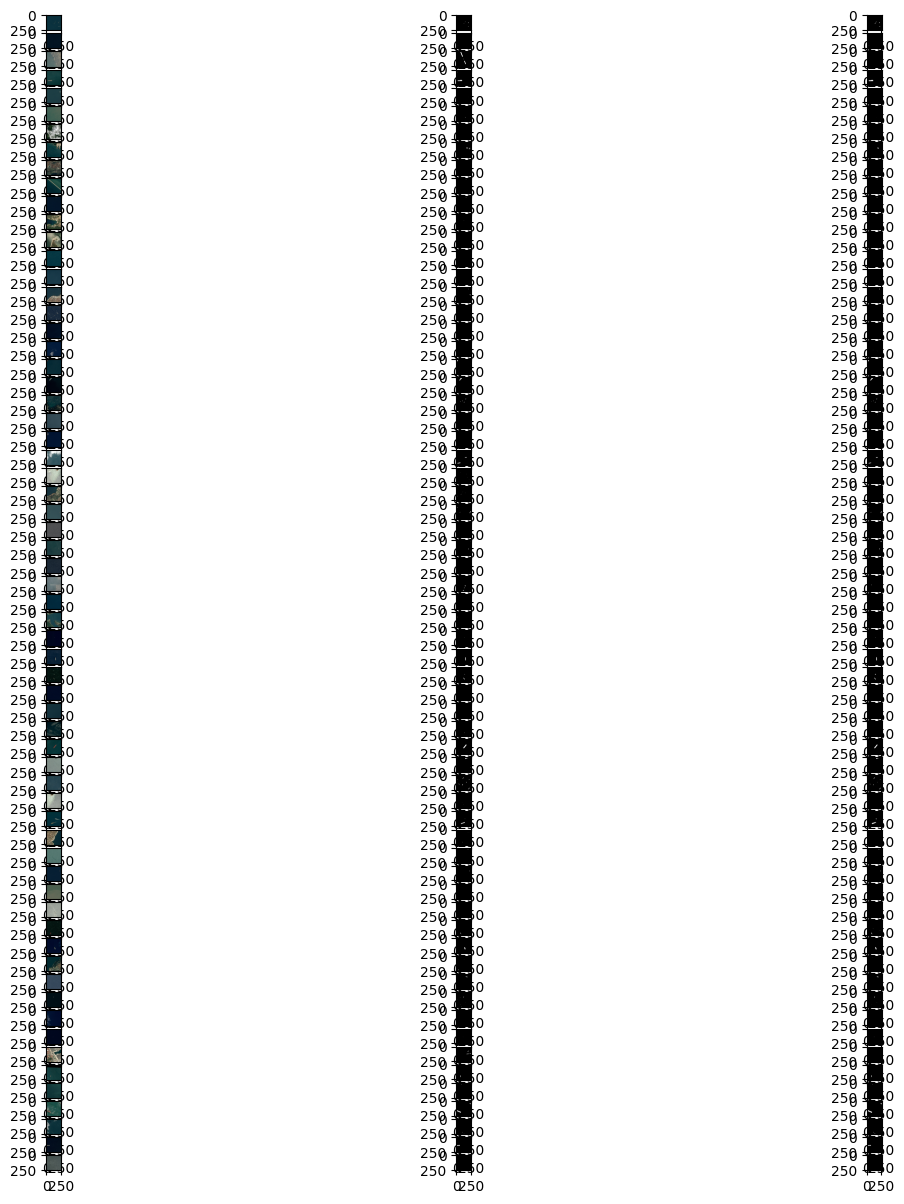

In [ ]:
for k in test_ds.take(1):
    images, masks = k[0].numpy(), k[1].numpy()
    predictions = model.predict(images)
    fig, axs = plt.subplots(images.shape[0], 3, figsize=(15, 15))
    # print(images[0])
    for i in range(images.shape[0]):
        # print(images[i])
        axs[i, 0].imshow(images[i])
        axs[i, 1].imshow(masks[i], cmap=cm.gray)
        axs[i, 2].imshow(predictions[i], cmap=cm.gray)
        plt.imsave(f'results/img_{i}.jpg', images[i])
        plt.imsave(f'results/gtr_{i}.jpg', masks[i].reshape(image_shape), cmap=cm.gray)
        plt.imsave(f'results/pred_{i}.jpg', predictions[i].reshape(image_shape), cmap=cm.gray)
    
    #     axs[i, 0].imshow(image_mask[0])
    #     axs[i, 1].imshow(mask, cmap=cm.gray)
    plt.show()

Я не знаю почему код сломался и не отображает нормально изображения))

In [ ]:
!zip -rq results.zip results

In [ ]:
os.system('cp results.zip drive/MyDrive/')

0

Попробуем обучить модель с предварительно обученным кодировщиком

In [ ]:
!pip install segmentation-models==1.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.9 MB/s eta 0:00:00


In [ ]:
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [ ]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
# train_ds_sm = preprocess_input(train_ds)
# valid_ds_sm = preprocess_input(valid_ds)
test_ds_sm = preprocess_input(test_ds)

In [ ]:
model_sm = sm.Unet(BACKBONE, encoder_weights='imagenet')
model_sm.compile(
    'Adam',
    loss=sm.losses.DiceLoss(smooth=100),
    metrics=[sm.metrics.iou_score, sm.metrics.f1_score],
)

85521592/85521592 [==============================] - 2s 0us/step


In [ ]:
es = EarlyStopping(patience=5, restore_best_weights=True)
mchp = ModelCheckpoint('drive/MyDrive/model_sm.h5', save_best_only=True)
rlr = ReduceLROnPlateau(factor=0.5, patience=1)

In [ ]:
history_sm = model_sm.fit(
   train_ds_sm,
   batch_size=batch_size,
   epochs=15,
   validation_data=valid_ds_sm,
   callbacks=[es, mchp, rlr]
)

Epoch 1/15
662/662 [==============================] - 673s 943ms/step - loss: 0.3278 - iou_score: 0.5302 - f1-score: 0.6715 - val_loss: 0.6231 - val_iou_score: 0.2299 - val_f1-score: 0.3619 - lr: 0.0010
Epoch 2/15
662/662 [==============================] - 626s 940ms/step - loss: 0.2166 - iou_score: 0.6462 - f1-score: 0.7827 - val_loss: 0.2262 - val_iou_score: 0.6350 - val_f1-score: 0.7735 - lr: 0.0010
Epoch 3/15
662/662 [==============================] - 626s 939ms/step - loss: 0.2074 - iou_score: 0.6583 - f1-score: 0.7919 - val_loss: 0.2179 - val_iou_score: 0.6421 - val_f1-score: 0.7806 - lr: 0.0010
Epoch 4/15
662/662 [==============================] - 630s 945ms/step - loss: 0.1814 - iou_score: 0.6941 - f1-score: 0.8180 - val_loss: 0.1999 - val_iou_score: 0.6713 - val_f1-score: 0.8001 - lr: 0.0010
Epoch 5/15
662/662 [==============================] - 631s 946ms/step - loss: 0.1736 - iou_score: 0.7054 - f1-score: 0.8258 - val_loss: 0.1962 - val_iou_score: 0.6737 - val_f1-score: 0.803

In [ ]:
model_sm.load_weights('drive/MyDrive/model_sm.h5')

Эта модель будет получше

In [ ]:
model_sm.evaluate(test_ds)

147/147 [==============================] - 100s 545ms/step - loss: 0.1762 - iou_score: 0.7020 - f1-score: 0.8237


[0.17617477476596832, 0.7019520998001099, 0.8237027525901794]

In [ ]:
os.mkdir('results_sm')

2/2 [==============================] - 5s 17ms/step


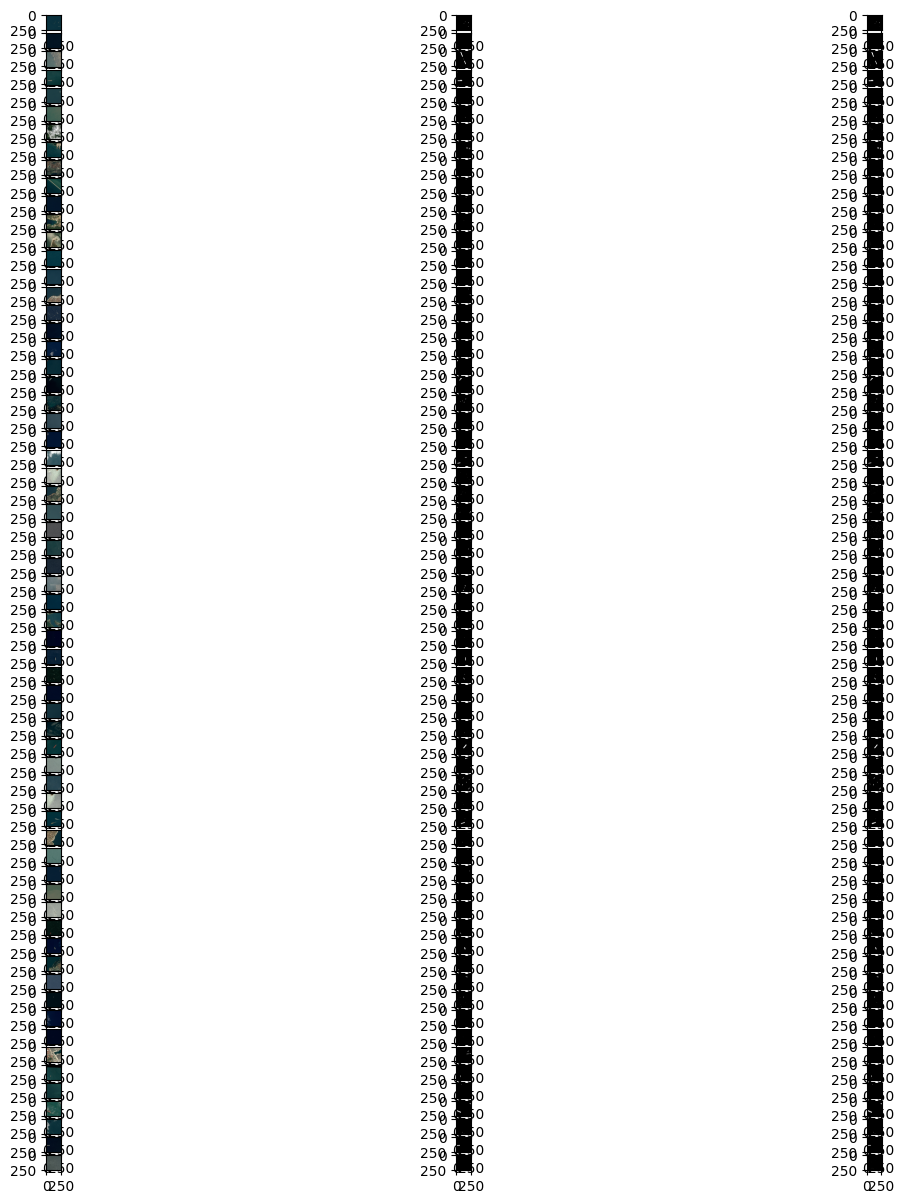

In [ ]:
for k in test_ds.take(1):
    images, masks = k[0].numpy(), k[1].numpy()
    predictions = model_sm.predict(images)
    fig, axs = plt.subplots(images.shape[0], 3, figsize=(15, 15))
    # print(images[0])
    for i in range(images.shape[0]):
        # print(images[i])
        axs[i, 0].imshow(images[i])
        axs[i, 1].imshow(masks[i], cmap=cm.gray)
        axs[i, 2].imshow(predictions[i], cmap=cm.gray)
        plt.imsave(f'results_sm/img_{i}.jpg', images[i])
        plt.imsave(f'results_sm/gtr_{i}.jpg', masks[i].reshape(image_shape), cmap=cm.gray)
        plt.imsave(f'results_sm/pred_{i}.jpg', predictions[i].reshape(image_shape), cmap=cm.gray)
    
    #     axs[i, 0].imshow(image_mask[0])
    #     axs[i, 1].imshow(mask, cmap=cm.gray)
    plt.show()

In [ ]:
!zip -rq results_sm.zip results_sm

In [ ]:
os.system('mv results_sm.zip drive/MyDrive/')

0

Модель с предобученной частью показывает себя на тестах лучше. Далее собираем код по кускам и разносим по отдельным файлам. Для деплоя модели можно квантовать и обрезать незначимые веса. Это даст небольшой прирост скорости инференса и снизит вес модели, но немножко ухудшит ее метрики. В данном случае я ничего не оптимизировал.